In [8]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, lfilter, freqz, filtfilt, detrend
from scipy import stats
from scipy.io import loadmat

from cartopy import config
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean
import matplotlib.ticker as mticker
from cartopy.util import add_cyclic_point

In [9]:
# Set data paths
projpath = "/Users/gliu/Downloads/02_Research/01_Projects/01_AMV/02_stochmod/"
scriptpath = projpath + '03_Scripts/stochmod/'
datpath = projpath + '01_Data/'
outpath = projpath + '02_Figures/20200629/'

# Path to SST data from obsv
datpath2 = "/Users/gliu/Downloads/02_Research/01_Projects/01_AMV/00_Commons/01_Data/"



In [313]:
# Functions
def calc_lagcovar(var1,var2,lags,basemonth,detrendopt):
    import numpy as np
    from scipy import signal
    from scipy import stats
    
    
    
    debug = 0
    
    if debug == 1:
        basemonth = kmonth
        lags = lags
        var1 = temps
        var2 = temps
        detrendopt = 1
    
    # Get total number of lags
    lagdim = len(lags)
    
    # Get timeseries length
    totyr = var1.shape[1]
    
    # Get lag and lead sizes (in years)
    leadsize = int(np.ceil(len(np.where(lags < 0)[0])/12))
    lagsize = int(np.ceil(len(np.where(lags > 0)[0])/12))
    
    
    # Detrend variables if option is set
    if detrendopt == 1:
        var1 = signal.detrend(var1,1,type='linear')
        var2 = signal.detrend(var2,1,type='linear')
    
    # Get base timeseries to perform the autocorrelation on
    base_ts = np.arange(0+leadsize,totyr-lagsize)
    varbase = var1[basemonth-1,base_ts]
        
    # Preallocate Variable to store correlations
    corr_ts = np.zeros(lagdim)
    
    # Set some counters
    nxtyr = 0
    addyr = 0
    modswitch = 0
    
    for i in lags:
        
        
        lagm = (basemonth + i)%12
        
        if lagm == 0:
            lagm = 12
            addyr = 1         # Flag to add to nxtyr
            modswitch = i+1   # Add year on lag = modswitch
            
        if addyr == 1 and i == modswitch:
            print('adding year on '+ str(i))
            addyr = 0         # Reset counter
            nxtyr = nxtyr + 1 # Shift window forward
            
        # Index the other variable
        lag_ts = np.arange(0+nxtyr,len(varbase)+nxtyr)
        varlag = var2[lagm-1,lag_ts]
        
        # Calculate correlation
        corr_ts[i] = stats.pearsonr(varbase,varlag)[0]
            
        if lagm == 3:
            print(i)
            print(corr_ts[i])
            
            
    return corr_ts


def area_avg(data,bbox,lon,lat,wgt):
    """
    Function to find the area average of data [lon x lat x otherdim]
    
    Given a bounding box [lonW, lonE, latS, latN]
    
    and corresponding lon/lat variables

    """
    
    # If wgt == 1, apply area-weighting 
    if wgt == 1:
        wgt = np.cos(np.radians(lat))
        
        data = data * wgt[None,:,None]
    
    # Find lat/lon indices 
    kw = np.abs(lon - bbox[0]).argmin()
    ke = np.abs(lon - bbox[1]).argmin()
    ks = np.abs(lat - bbox[2]).argmin()
    kn = np.abs(lat - bbox[3]).argmin()
    
    # Select the region
    sel_data = data[kw:ke+1,ks:kn+1,:]
    
    # Take average over lon and lat
    data_aa = np.nanmean(sel_data,(0,1))
    
    return data_aa


# From here: https://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y



# Here: https://scitools.org.uk/iris/docs/v1.2/examples/graphics/SOI_filtering.html
def low_pass_weights(window, cutoff):
    """Calculate weights for a low pass Lanczos filter.

    Args:

    window: int
        The length of the filter window.

    cutoff: float
        The cutoff frequency in inverse time steps.

    """
    order = ((window - 1) // 2 ) + 1
    nwts = 2 * order + 1
    w = np.zeros([nwts])
    n = nwts // 2
    w[n] = 2 * cutoff
    k = np.arange(1., n)
    sigma = np.sin(np.pi * k / n) * n / (np.pi * k)
    firstfactor = np.sin(2. * np.pi * cutoff * k) / (np.pi * k)
    w[n-1:0:-1] = firstfactor * sigma
    w[n+1:-1] = firstfactor * sigma
    return w[1:-1]


def detrendlin(var_in):
    debug = 0
    if debug == 1:
        var_in = sssr[:,32]
    
    x = np.arange(0,len(var_in))
    
    # Limit to non-nan values
    inotnan = ~np.isnan(var_in)
    
    # Perform Regression
    m,b,r_val,p_val,std_err=stats.linregress(x[inotnan],var_in[inotnan])
    
    # Detrend
    var_detrend = var_in - (m*x +b)
    
    return var_detrend

In [314]:
# User settings (note, need to select better region that ignores stuff in the pacific)
bbox = [-75,5,0,65]

# Filter settings: https://iescoders.com/time-series-analysis-filtering-or-smoothing-the-data/
order   = 5
fs      = 1/(30*24*3600) # sampling frequency in Hz
nyquist = fs/2           # Nyquist is half thesampling frequency; 
timecut = 120            # in Months
cutoff  = 1/timecut/2     # desired cutoff frequency of the filter, Hz


# More filter settings rewritten (based on old matlab code)
order = 5
filtfreq = len(aa_hsst)/timecut
nyquist = len(aa_hsst)/2
cutoff = filtfreq/nyquist


print('cutoff = ',1/cutoff*nyquist*30*24*3600,' months')

cutoff =  139034880000.0  months


In [315]:
# Load in stochastic model output
F        = np.load(datpath+"stoch_output_1000yr_Forcing_01.npy")
t_noentr = np.load(datpath+"stoch_output_1000yr_entrain0_01.npy")
t_entr   = np.load(datpath+"stoch_output_1000yr_entrain1_01.npy")
lon      = np.load(datpath+"lon.npy")
lat      = np.load(datpath+"lat.npy")

t_noentr.shape

(81, 117, 12000)

In [316]:
# Load in observation SST data to compare

obvhad = loadmat(datpath2+"hadisst.1870_2018.mat")

hlat = np.squeeze(obvhad['LAT'])
hlon = np.squeeze(obvhad['LON'])
hyr  = obvhad['YR']
hsst = obvhad['SST']


# Change hsst to lon x lat x time
hsst = np.transpose(hsst,(2,1,0))




In [317]:


# For hsst, flip the latitude axis
# currently it is arranged 90:-90, need to flip to south first

# Find north and south latitude points
hsouth = np.where(hlat <= 0)
hnorth = np.where(hlat > 0)

# Find corresponding points in data
hsstsouth = np.squeeze(hsst[:,hsouth,:])[:,::-1,:]
hsstnorth = np.squeeze(hsst[:,hnorth,:])[:,::-1,:]

# Stitch things together, reversing the order 
hlatnew = np.squeeze(np.concatenate((hlat[hsouth][::-1],hlat[hnorth][::-1])))
hsstnew = np.concatenate((hsstsouth,hsstnorth),axis=1)

In [318]:
# Take area average
aa_noentr = area_avg(t_noentr,bbox,lon,lat,1)
aa_entr   = area_avg(t_entr,bbox,lon,lat,1)
aa_F      = area_avg(F,bbox,lon,lat,1)


aa_hsst   = area_avg(hsstnew,bbox,hlon,hlatnew,1)

/Users/gliu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/gliu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [319]:
# Detrend the data linearly


# aa_noentr = detrendlin(aa_noentr)
# aa_entr   =  detrendlin(aa_entr)
# aa_F      =  detrendlin(aa_F)

undetrended = np.copy(aa_hsst)
aa_hsst    = detrendlin(aa_hsst)



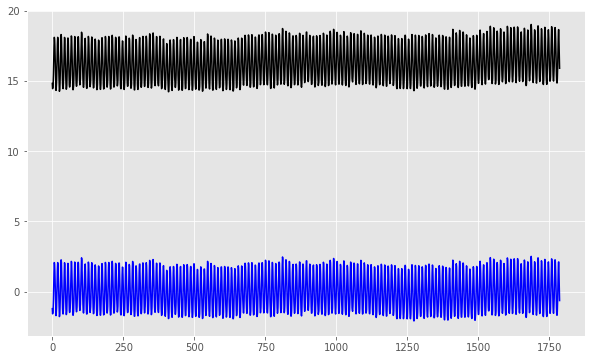

In [301]:
#Visualize detrending


htimefull = np.arange(0,1788)
htimetick = np.arange(0,1788,12*20)
hyrlabel   = np.squeeze(hyr[:,0:-1:20])

fig,ax = plt.subplots()

ax.plot(htimefull,undetrended,label="Raw",color='k')
ax.plot(htimefull,aa_hsst,label="detrended",color="b")

In [302]:
# Normalize the data

hmean = np.nanmean(aa_hsst)
hstd  = np.nanstd(aa_hsst)
hanom = (aa_hsst - hmean)/hstd
aa_hsst = np.copy(hanom)



In [303]:
# Apply low pass filter to stochastic model output

b, a = butter(order, cutoff, btype='lowpass')

lp_noentr = filtfilt(b,a,aa_noentr)
lp_entr   = filtfilt(b,a,aa_entr)
lp_f      = filtfilt(b,a,aa_F)


# More filter settings rewritten (based on old matlab code)
order = 5
filtfreq = len(aa_hsst)/timecut
nyquist = len(aa_hsst)/2
cutoff = filtfreq/nyquist
bh, ah = butter(order, cutoff, btype='lowpass')
lp_hsst   = filtfilt(bh,ah,aa_hsst)

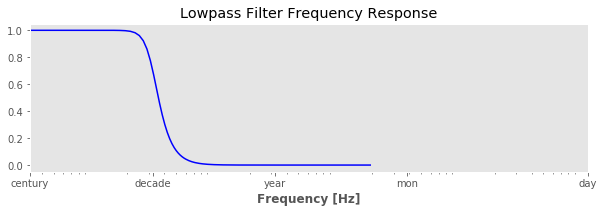

In [304]:
# Visualize frequency response

# Set xticks
xtk     = [fs/1200,fs/120,fs/12,fs,fs*30]
xtklabel = ['century','decade','year','mon',"day"]


w, h = freqz(b, a, worN=1000)
plt.subplot(2, 1, 1)


plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(fs/1200, 0.5*fs)
plt.xscale('log')
plt.xticks(xtk,xtklabel)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

Text(0.5, 1.0, 'No Entrainment')

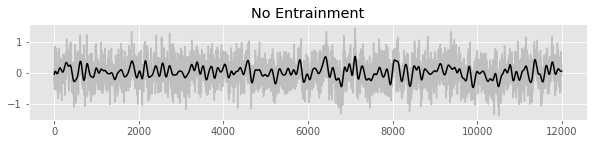

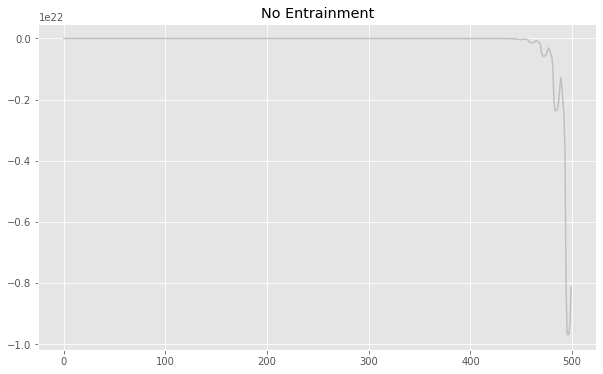

In [305]:
# Plot Time series

from matplotlib import rcParams
rcParams['figure.figsize'] = (10.0, 6.0) #predefine the size of the figure window
rcParams.update({'font.size': 14}) # setting the default fontsize for the figure
rcParams['axes.labelweight'] = 'bold' #Bold font style for axes labels
from matplotlib import style
style.use('ggplot') #I personally like to use "ggplot" style of graph for my work but it depends on the user's preference whether they wanna use it.

# Visualizing the original and the Filtered Time Series
fig = plt.figure()
ax = fig.add_subplot(3, 1, 1)
#ax.plot(np.arange(0,12000),aa_noentr,label="Unfiltered, No Entrain",color='k')
ax.plot(np.arange(0,12000),aa_noentr,label="Unfiltered, No Entrain",color=(0.75,0.75,0.75))
ax.plot(np.arange(0,12000),lp_noentr,color='k',label="Low Pass, No Entrain")
ax.set_title("No Entrainment")



# IT SEEMS that the entrainment run is going crazy....
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
tend = 500
#ax.plot(np.arange(0,12000),aa_noentr,label="Unfiltered, No Entrain",color='k')
ax.plot(np.arange(0,tend),aa_entr[:tend],label="Unfiltered, Entrain",color=(0.75,0.75,0.75))
#ax.plot(np.arange(0,12000),lp_entr,color='k',label="Low Pass, Entrain")
ax.set_title("No Entrainment")







[Text(0, 0, '1870'),
 Text(0, 0, '1890'),
 Text(0, 0, '1910'),
 Text(0, 0, '1930'),
 Text(0, 0, '1950'),
 Text(0, 0, '1970'),
 Text(0, 0, '1990'),
 Text(0, 0, '2010')]

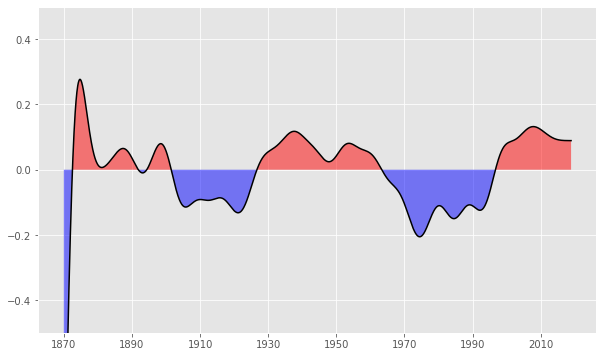

In [306]:
# Plot time series for Hadley-SST

htimefull = np.arange(0,1788)
htimetick = np.arange(0,1788,12*20)
hyrlabel   = np.squeeze(hyr[:,0:-1:20])

fig,ax = plt.subplots()

ax.plot(htimefull,lp_hsst,color="k")
ax.fill_between(htimefull,0,lp_hsst,where=lp_hsst>0,facecolor='red',interpolate=True,alpha=0.5)
ax.fill_between(htimefull,0,lp_hsst,where=lp_hsst<0,facecolor='blue',interpolate=True,alpha=0.5)
#ax.set_xticks(htimetick,hyr)
ax.set_ylim(-0.5,0.5)
ax.set_xticks(ticks=htimetick)
ax.set_xticklabels(hyrlabel)


In [307]:
lp_noentr.shape

(12000,)

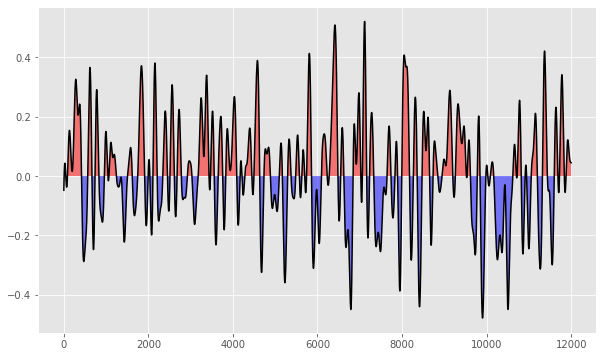

In [308]:
# AMV Index Plot (Filled Area)

# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1)

fig,ax=plt.subplots()

#
#ax.plot(np.arange(0,12000),aa_noentr,label="Unfiltered, No Entrain",color=(0.75,0.75,0.75))
ax.plot(np.arange(0,12000),lp_noentr,color='k')

ax.fill_between(np.arange(0,12000),0,lp_noentr,where=lp_noentr>0,facecolor='red',interpolate=True,alpha=0.5)
ax.fill_between(np.arange(0,12000),0,lp_noentr,where=lp_noentr<0,facecolor='blue',interpolate=True,alpha=0.5)


In [309]:
# Lets try to write a regression function to get the spatial pattern assoc with this
ts  = np.copy(lp_hsst)
var = np.copy(hsstnew)


# Anomalize and normalize the data
normalizeall = 0
if normalizeall == 1:
    varmean = np.nanmean(var,2)
    varstd  = np.nanstd(var,2)
    var = (var - varmean[:,:,None]) /varstd[:,:,None]



# Combine the spatial dimensions 
londim = var.shape[0]
latdim = var.shape[1]
var = np.reshape(var,(londim*latdim,var.shape[2]))


# Perform the regression via matrix multiplication (do we need to anomalize things and do the squared portion in the denominator?)
var_reg = np.matmul(np.ma.anomalies(var,axis=1),np.ma.anomalies(ts,axis=0))/len(ts)

# Reshape
var_reg = np.reshape(var_reg,(londim,latdim))










In [310]:
# Trying a different regresion function
# Lets try to write a regression function to get the spatial pattern assoc with this
ts  = np.copy(lp_hsst)
var = np.copy(hsstnew)

# Select starting year
startyr = 1920
monstart = (1920-hyr[0,0])*12


# Anomalize and normalize the data
normalizeall = 0
if normalizeall == 1:
    varmean = np.nanmean(var,2)
    varstd  = np.nanstd(var,2)
    var = (var - varmean[:,:,None]) /varstd[:,:,None]
    

# Get shapes
londim = var.shape[0]
latdim = var.shape[1] 
icount = 0

# Loop lat and long
var_reg = np.zeros((londim,latdim))
for o in range(londim):
    for a in range(latdim):
        
        # Get time series for that period
        vartime = np.squeeze(var[o,a,:])
        
        if any(np.isnan(vartime)):
            var_reg[o,a]=np.nan
            continue
        
        # Perform regression 
        var_reg[o,a]=stats.pearsonr(vartime[monstart::],ts[monstart::])[0]
        
#         icount += 1
#         msg = '\rRegressed %i of %i points' % (icount,londim*latdim)
#         print(msg,end="\r",flush=True)

print("Regression completed!")

            
            
        
        
        


Regression completed!


Text(0.5, 1.0, 'AMV-related SST Pattern from HadISST, 1920-2018')

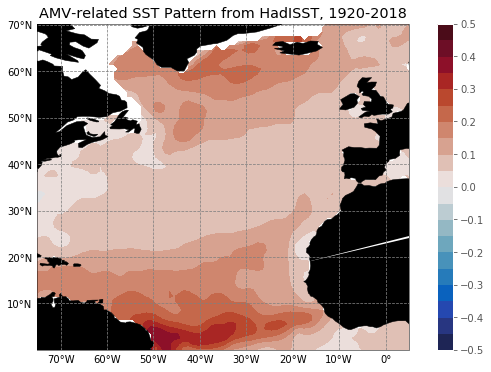

In [311]:
# Plot the correlation map
cmap = cmocean.cm.balance

cint = np.arange(-0.50,0.55,0.05)
clab = np.arange(-0.50,0.60,0.10)


# Add cyclic point
var_reg1 = np.transpose(var_reg,(1,0))
var_reg1,lon1 = add_cyclic_point(var_reg1,coord=hlon)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(bbox)

ax.add_feature(cfeature.COASTLINE,facecolor='k')
#ax.background_patch.set_fill(False)

cs = ax.contourf(lon1,hlatnew,var_reg1,cint,cmap=cmap)
# Contour fill
# cs = ax.contourf(lon,lat,var,
#            cint,
#            cmap=cmap,
#            transform=ccrs.PlateCarree())


# # Negative contours
# cln = ax.contour(lon,lat,var,
#            cint[cint<0],
#            linestyles='dashed',
#            colors='k',
#            linewidths=0.5,
#            transform=ccrs.PlateCarree())

# # Positive Contours
# clp = ax.contour(lon,lat,var,
#            cint[cint>=0],
#            colors='k',
#            linewidths=0.5,
#            transform=ccrs.PlateCarree())    
                  
                
                                
                
                
gl = ax.gridlines(draw_labels=True,linewidth=0.75,color='gray',linestyle='--')

gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
plt.colorbar(cs,ticks=clab)
ax.set_title("AMV-related SST Pattern from HadISST, %i-%i"%(startyr,hyr[0,-1]))

TypeError: Length of y must be number of rows in z.

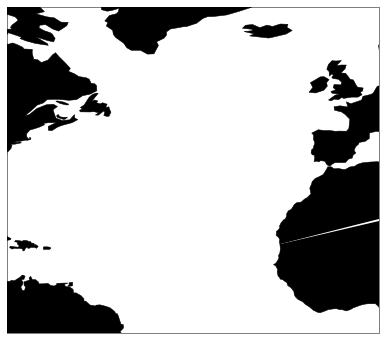

In [312]:
# Plot the correlation map
cmap = cmocean.cm.thermal
# Add cyclic point

var_reg1 = np.transpose(var_reg,(1,0))
var_reg1,lon1 = add_cyclic_point(var_reg1,coord=hlon)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(bbox)

ax.add_feature(cfeature.COASTLINE,facecolor='k')
#ax.background_patch.set_fill(False)

cs = ax.contourf(lon1,lat,var_reg1,cmap=cmap)
# Contour fill
# cs = ax.contourf(lon,lat,var,
#            cint,
#            cmap=cmap,
#            transform=ccrs.PlateCarree())


# # Negative contours
# cln = ax.contour(lon,lat,var,
#            cint[cint<0],
#            linestyles='dashed',
#            colors='k',
#            linewidths=0.5,
#            transform=ccrs.PlateCarree())

# # Positive Contours
# clp = ax.contour(lon,lat,var,
#            cint[cint>=0],
#            colors='k',
#            linewidths=0.5,
#            transform=ccrs.PlateCarree())    
                  
                
                                
                
                
gl = ax.gridlines(draw_labels=True,linewidth=0.75,color='gray',linestyle='--')

gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
plt.colorbar(cs)

In [227]:
var_reg.shape

(81, 117)